In [2]:
#!pip install mediapipe
!pip install mediapipe -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
# Unzip the dataset
!unzip -q handgesturefinal.zip -d /content/

In [4]:
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from torch.utils.data import Dataset # 仍需繼承 Dataset
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

--- Stage 1: Starting to process images and generate skeleton data ---
Scanning and extracting skeletons from /content/asl_dataset/train/images...
Scan complete. Successfully detected skeletons: 1251, Failed detections: 261



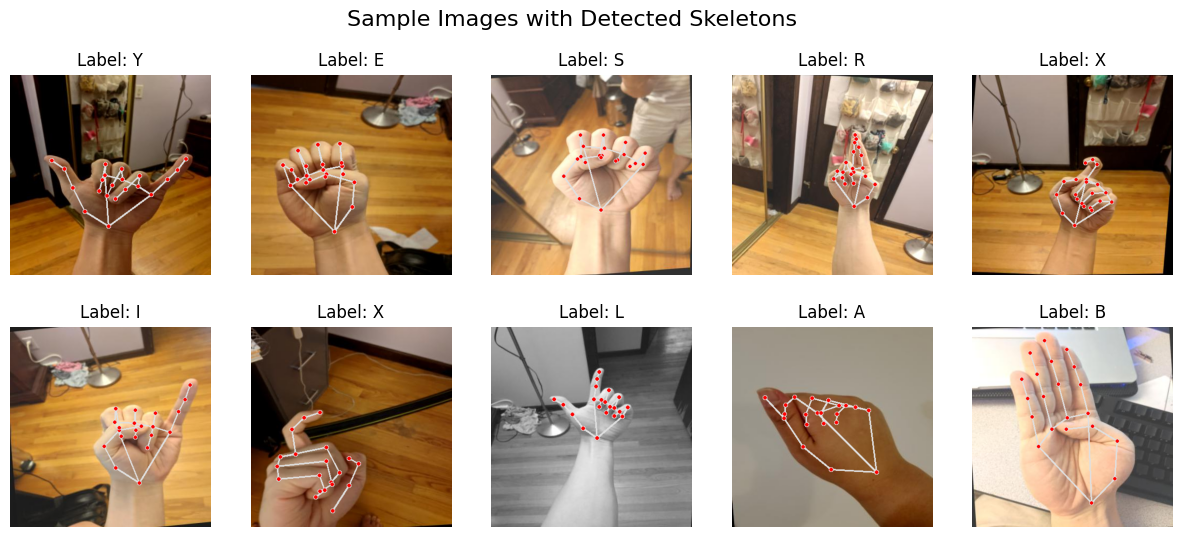

In [17]:
# ==============================================================================
# Stage 1: Extract Skeleton Data (mostly same as the previous version)
# ==============================================================================
print("--- Stage 1: Starting to process images and generate skeleton data ---")

class HandLandmarkExtractor(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.landmark_data = []
        self.labels = []
        self.processed_images_for_display = []
        self.labels_for_display = []
        self.class_to_idx = {}
        self.classes = []


        mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

        self._prepare_dataset()

    def _prepare_dataset(self):
        success_count = 0
        failure_count = 0

        # Adjust the data_dir to point to the correct subdirectory within asl_dataset
        full_data_dir = os.path.join(self.data_dir, 'images') # Point to the 'images' subdirectory within the split directory

        if not os.path.isdir(full_data_dir):
            raise FileNotFoundError(f"Error: Images directory '{full_data_dir}' not found. Please check the path.")

        # Manually process the directory structure as ImageFolder expects class subfolders
        image_paths = [os.path.join(full_data_dir, f) for f in os.listdir(full_data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(image_paths) # Shuffle to get a diverse sample for display

        # Extract labels from filenames (assuming format like 'A1_jpg...', 'B2_png...')
        # Create a mapping of class names to indices
        all_labels = sorted(list(set([os.path.basename(p)[0] for p in image_paths])))
        self.classes = all_labels
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}


        print(f"Scanning and extracting skeletons from {full_data_dir}...")
        for path in image_paths:
            img = cv2.imread(path)
            if img is None:
                failure_count += 1
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = self.hands.process(img_rgb)

            if results.multi_hand_landmarks:
                success_count += 1
                hand_landmarks = results.multi_hand_landmarks[0]

                data_aux = []
                for landmark in hand_landmarks.landmark:
                    data_aux.extend([landmark.x, landmark.y, landmark.z])

                self.landmark_data.append(data_aux)

                # Extract label from filename and convert to index
                label_name = os.path.basename(path)[0]
                label_idx = self.class_to_idx.get(label_name, -1) # Use .get() with a default for safety
                if label_idx != -1:
                    self.labels.append(label_idx)
                else:
                    print(f"Warning: Could not find index for label '{label_name}' from file '{path}'. Skipping.")
                    # If a label is not found, you might want to skip adding this data point
                    self.landmark_data.pop() # Remove the landmark data if label was not found


                # Store a few images with skeletons for display
                if len(self.processed_images_for_display) < 10 and label_idx != -1:
                    image_to_draw = img.copy()
                    self.mp_drawing.draw_landmarks(image_to_draw, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
                    self.processed_images_for_display.append(image_to_draw)
                    self.labels_for_display.append(label_name) # Store the label name for display
            else:
                failure_count += 1

        print(f"Scan complete. Successfully detected skeletons: {success_count}, Failed detections: {failure_count}\n")

    def get_data_for_sklearn(self):
        """Provides NumPy arrays for use with scikit-learn."""
        # Ensure landmark_data and labels have the same length
        min_len = min(len(self.landmark_data), len(self.labels))
        return np.array(self.landmark_data[:min_len]), np.array(self.labels[:min_len])

# --- Set up paths and extract data ---
train_data_dir = '/content/asl_dataset/train' # Point to the 'train' split of the new dataset

if not os.path.isdir(os.path.join(train_data_dir, 'images')): # Check for the 'images' subdirectory within 'train'
    raise FileNotFoundError(f"Error: Training images directory '{os.path.join(train_data_dir, 'images')}' not found. Please check the path.")

# Instantiate the class and extract data
feature_extractor = HandLandmarkExtractor(train_data_dir)
X, y = feature_extractor.get_data_for_sklearn()

# Display sample images with successfully detected skeletons
if feature_extractor.processed_images_for_display:
    plt.figure(figsize=(15, 6))
    plt.suptitle("Sample Images with Detected Skeletons", fontsize=16)
    for i, img in enumerate(feature_extractor.processed_images_for_display):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {feature_extractor.labels_for_display[i]}")
        plt.axis('off')
    plt.show()


--- Stage 2: Starting to train a Random Forest model with scikit-learn ---
Feature data (X) shape: (1251, 63)
Training set size: 1000
Test set size: 251

Training the Random Forest model...
Model training complete!


Model successfully saved to: random_forest_hand_model.joblib
--- Model Evaluation ---
Model accuracy on the test set: 84.46%

Classification Report:
              precision    recall  f1-score   support

           A       0.79      0.85      0.81        13
           B       1.00      0.86      0.92         7
           C       0.75      0.86      0.80         7
           D       0.82      1.00      0.90         9
           E       0.82      0.90      0.86        10
           F       1.00      1.00      1.00        10
           G       1.00      1.00      1.00         9
           H       1.00      0.86      0.92         7
           I       1.00      1.00      1.00        14
           J       0.73      0.79      0.76        14
           K       0.90      1.00     

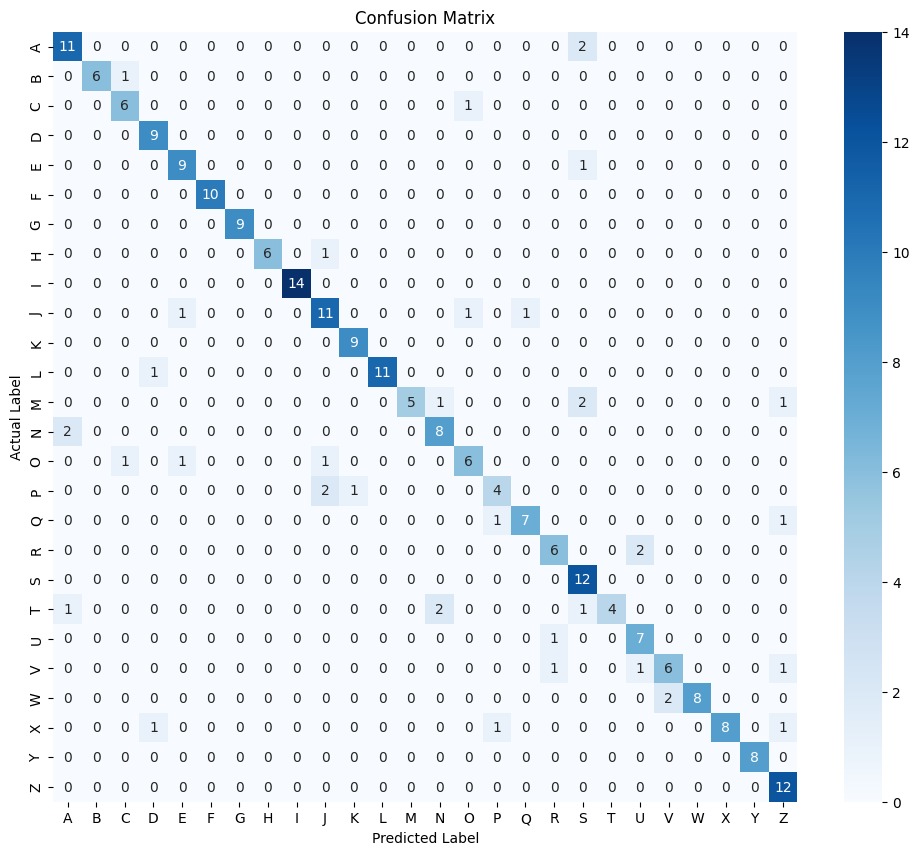

In [18]:

# ==============================================================================
# Stage 2: Train a Random Forest Model using scikit-learn
# ==============================================================================
print("\n--- Stage 2: Starting to train a Random Forest model with scikit-learn ---")

if len(X) == 0:
    print("No available data to train the model. Terminating the program.")
else:
    # --- 1. Split the data into training and testing sets ---
    # Split all data using an 80/20 ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Feature data (X) shape: {X.shape}")
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}\n")

    # --- 2. Create and train the Random Forest Classifier ---
    print("Training the Random Forest model...")
    # n_estimators is the number of trees in the forest, a key hyperparameter.
    # class_weight='balanced' automatically handles class imbalance issues.
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    print("Model training complete!\n")

    # 1. Define the filename for the saved model
    model_filename = 'random_forest_hand_model.joblib'

    # 2. Save the model using joblib.dump
    joblib.dump(model, model_filename)

    print(f"\nModel successfully saved to: {model_filename}")

    # --- 3. Make predictions on the test set and evaluate ---
    print("--- Model Evaluation ---")
    y_pred = model.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy on the test set: {accuracy * 100:.2f}%\n")

    # Print a detailed classification report (including Precision, Recall, F1-score)
    # target_names needs to be a list of strings
    class_names = feature_extractor.classes
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # --- 4. Visualize the Confusion Matrix ---
    print("Plotting the confusion matrix...")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

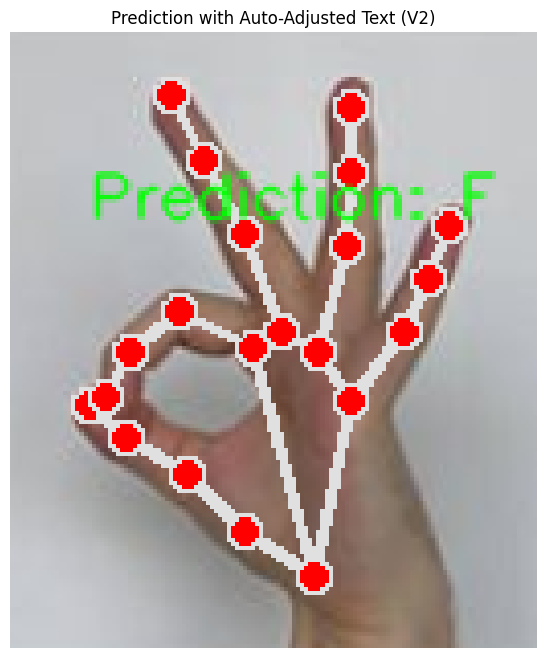

In [19]:
# --- 1. Helper Function: Create Label-to-Index Mapping ---
# To convert the model's predicted numbers (0, 1, 2...) back to class names ('A', 'B', 'C'...)
def get_label_mapping(data_dir):
    """Scans a directory and creates a dictionary mapping an index to a class name."""
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    idx_to_label = {i: label for i, label in enumerate(class_names)}
    return idx_to_label

def predict_and_visualize(model_path, image_path, idx_to_label_map):
    """
    Loads the model, performs skeleton detection and prediction on a new image,
    and visualizes the result with dynamically adjusted text position and size.
    (V2: Adjusted font size formula)
    """
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_path}'.")
        return

    # Lowering the confidence threshold is recommended to improve the detection rate
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2) #<-- Recommended to lower from 0.3 to 0.2

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read the image at '{image_path}'.")
        return

    image_to_draw = img.copy()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    prediction_text = "No Hand Detected"

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]

        # --- Extract coordinates for prediction ---
        data_aux = []
        h, w, _ = image_to_draw.shape
        x_coords_px = [int(landmark.x * w) for landmark in hand_landmarks.landmark]
        y_coords_px = [int(landmark.y * h) for landmark in hand_landmarks.landmark]

        for landmark in hand_landmarks.landmark:
            data_aux.extend([landmark.x, landmark.y, landmark.z]) # Include the z-coordinate

        landmarks_for_prediction = np.array(data_aux).reshape(1, -1)
        prediction_idx = model.predict(landmarks_for_prediction)[0]
        predicted_class = idx_to_label_map.get(prediction_idx, "Unknown")
        prediction_text = f"Prediction: {predicted_class}"

        # --- Draw skeleton ---
        mp_drawing.draw_landmarks(image_to_draw, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # --- (Adjustment) Dynamically calculate text position and size ---
        x_min, x_max = min(x_coords_px), max(x_coords_px)
        y_min, _ = min(y_coords_px), max(y_coords_px)

        text_x = x_min
        text_y = y_min - 15 if y_min > 20 else y_min + 30

        # --- Main adjustment is here ---
        # 1. Increase the denominator (e.g., from 200 -> 300) to make the base font smaller.
        # 2. Decrease the multiplier (e.g., from 1.2 -> 1.0).
        font_scale = max(0.5, (x_max - x_min) / 300.0 * 1.0)
        font_thickness = max(1, int(font_scale * 2))

        # Write the prediction text at the dynamically calculated position (using green)
        cv2.putText(image_to_draw, prediction_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

    else: # If no hand is detected
        # Display a red notification text in the top-left corner with a fixed font size of 1
        cv2.putText(image_to_draw, prediction_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # --- Display the result ---
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_to_draw, cv2.COLOR_BGR2RGB))
    plt.title("Prediction with Auto-Adjusted Text (V2)")
    plt.axis('off')
    plt.show()


model_filename = 'random_forest_hand_model.joblib'
train_dir = '/content/train'
new_image_path = '/content/F.png' # <--- Change to your own image path

try:
    idx_to_label = get_label_mapping(train_dir)
    predict_and_visualize(model_filename, new_image_path, idx_to_label)
except Exception as e:
    print(f"An error occurred: {e}")

In [12]:
# Create necessary directories
os.makedirs('asl_dataset', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('videos', exist_ok=True)

# Download the ASL dataset
print("📥 Downloading ASL dataset...")
!curl -L "https://public.roboflow.com/ds/FctikO6r4f?key=EAS4CeZh12" > roboflow.zip
!unzip -q roboflow.zip -d asl_dataset
!rm roboflow.zip

print("✅ Dataset download complete.")

# Check the dataset structure
print("\n📊 Dataset Structure:")
!ls -la asl_dataset/

# View the dataset configuration file
print("\n📋 Dataset Configuration:")
!cat asl_dataset/data.yaml

📥 Downloading ASL dataset...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1239      0 --:--:-- --:--:-- --:--:--  1238
100 22.4M  100 22.4M    0     0  6017k      0  0:00:03  0:00:03 --:--:-- 11.1M
✅ Dataset download complete.

📊 Dataset Structure:
total 32
drwxr-xr-x 5 root root 4096 Sep 20 11:52 .
drwxr-xr-x 1 root root 4096 Sep 20 11:52 ..
-rw-r--r-- 1 root root  424 Jan 20  2023 data.yaml
-rw-r--r-- 1 root root 1308 Jan 20  2023 README.dataset.txt
-rw-r--r-- 1 root root 1361 Jan 20  2023 README.roboflow.txt
drwxr-xr-x 4 root root 4096 Jan 20  2023 test
drwxr-xr-x 4 root root 4096 Jan 20  2023 train
drwxr-xr-x 4 root root 4096 Jan 20  2023 valid

📋 Dataset Configuration:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',